In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

(X_train, _), (_, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

generator = build_generator()

In [3]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
discriminator.trainable = False

gan_input = Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

def train_gan(epochs, batch_size=128):
    X_train, _ = mnist.load_data()
    X_train = (X_train[0].astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_images(epoch)

def save_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(r, c)
    count = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    fig.savefig(f"gan_images_{epoch}.png")
    plt.close()

train_gan(epochs=10000, batch_size=64)

2/2 [==============================] - 0s 6ms/step
0 [D loss: 0.6989712119102478, acc.: 57.03125] [G loss: 0.7226895093917847]
2/2 [==============================] - 0s 4ms/step
100 [D loss: 0.010453587863594294, acc.: 100.0] [G loss: 4.668925762176514]
2/2 [==============================] - 0s 5ms/step
200 [D loss: 0.07524169003590941, acc.: 97.65625] [G loss: 4.509626388549805]
2/2 [==============================] - 0s 4ms/step
300 [D loss: 0.2568301558494568, acc.: 95.3125] [G loss: 3.024862766265869]
2/2 [==============================] - 0s 4ms/step
400 [D loss: 0.6567303240299225, acc.: 42.96875] [G loss: 0.6537902355194092]
2/2 [==============================] - 0s 4ms/step
500 [D loss: 0.6280191242694855, acc.: 52.34375] [G loss: 0.6679366230964661]
2/2 [==============================] - 0s 4ms/step
600 [D loss: 0.6282486319541931, acc.: 63.28125] [G loss: 0.707013726234436]
2/2 [==============================] - 0s 5ms/step
700 [D loss: 0.6257672160863876, acc.: 66.40625] [G l

KeyboardInterrupt: 

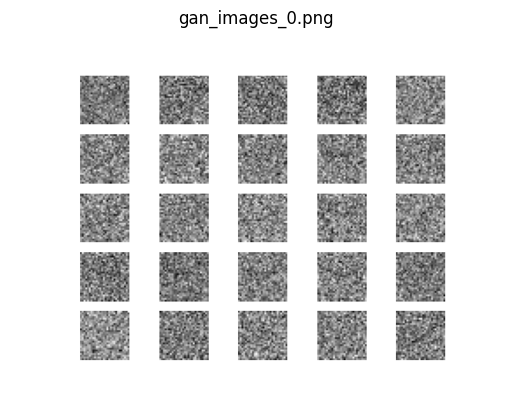

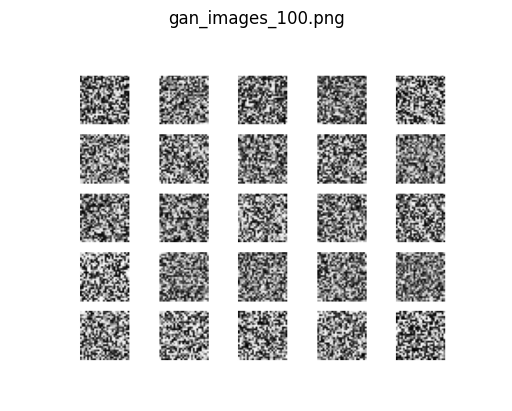

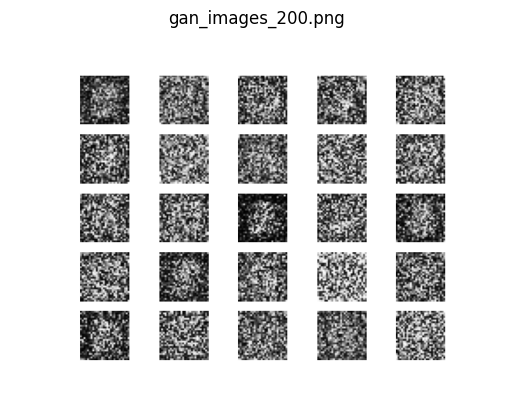

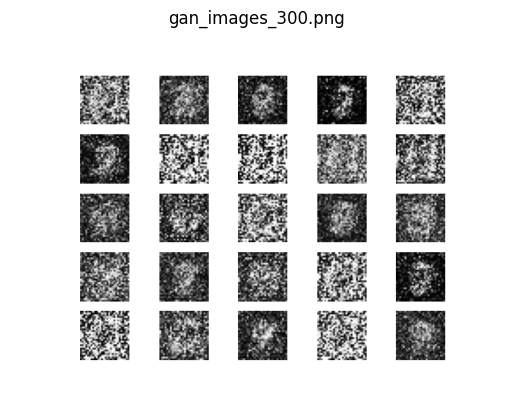

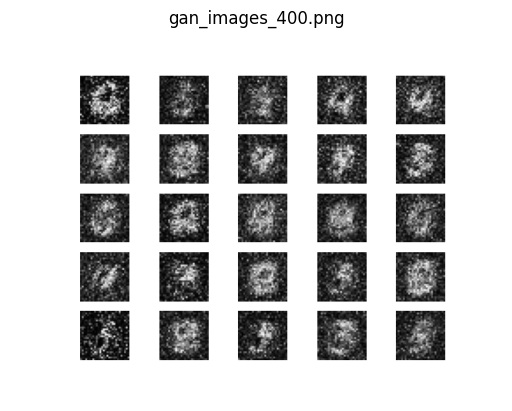

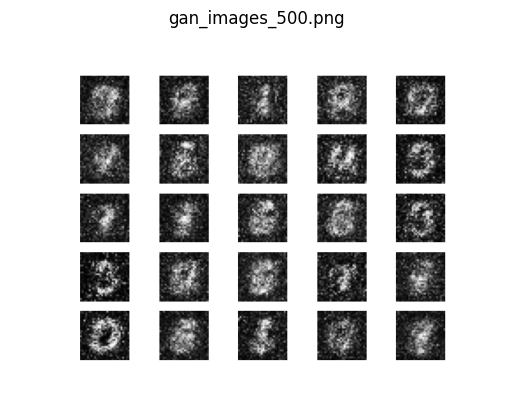

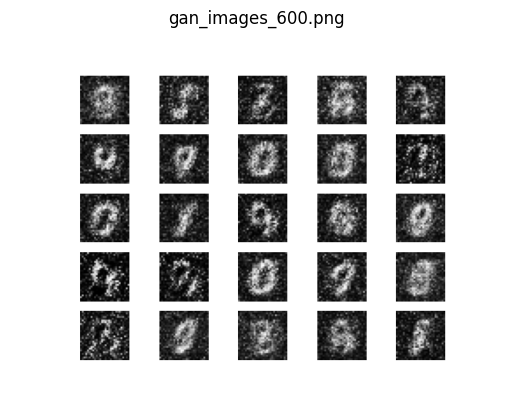

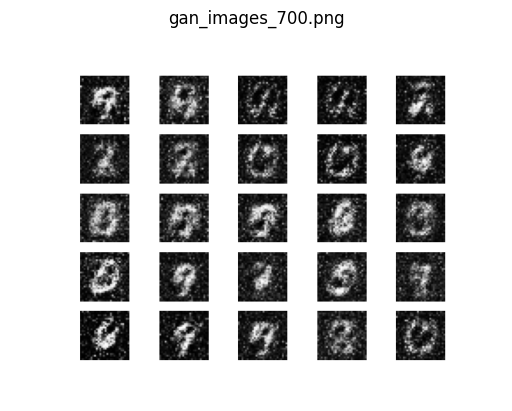

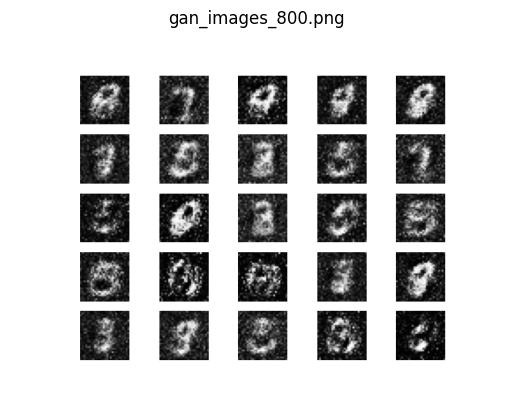

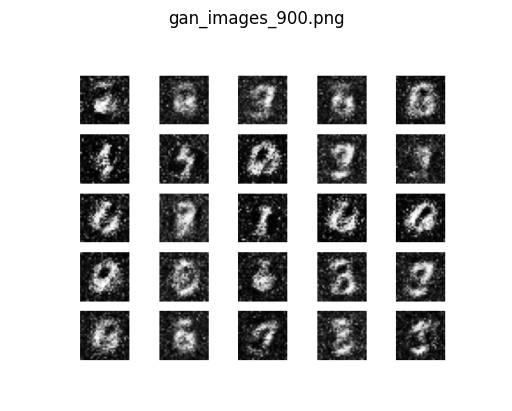

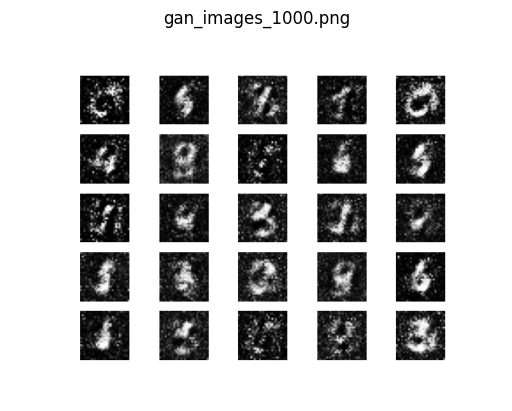

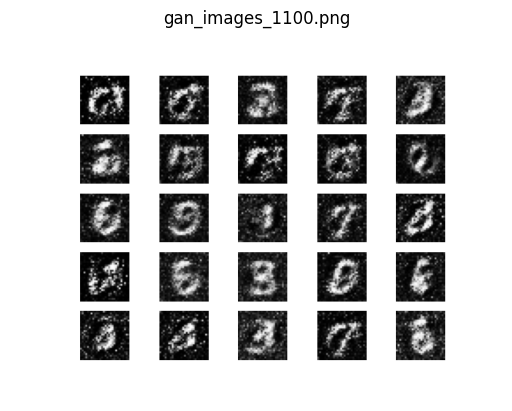

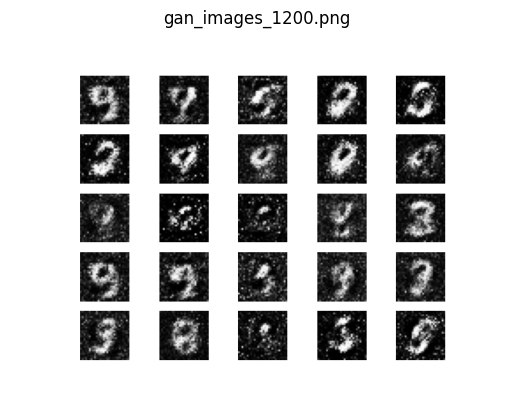

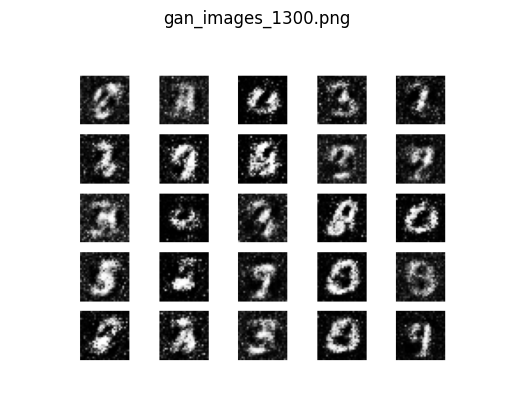

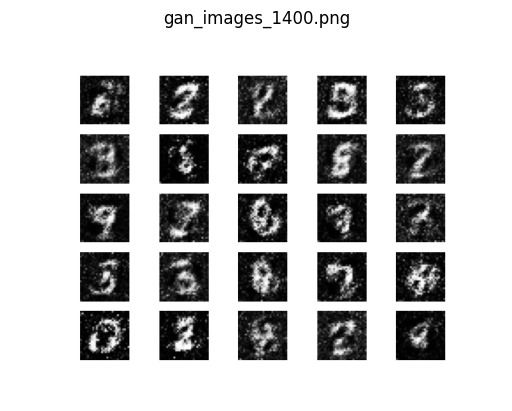

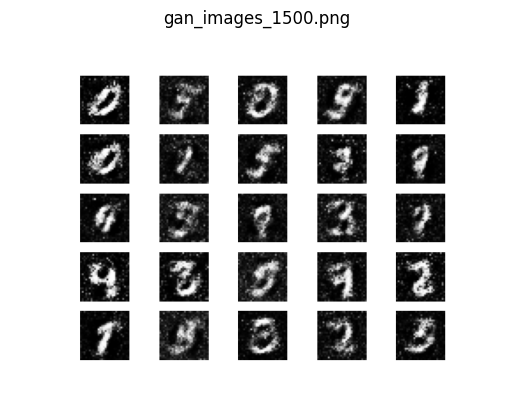

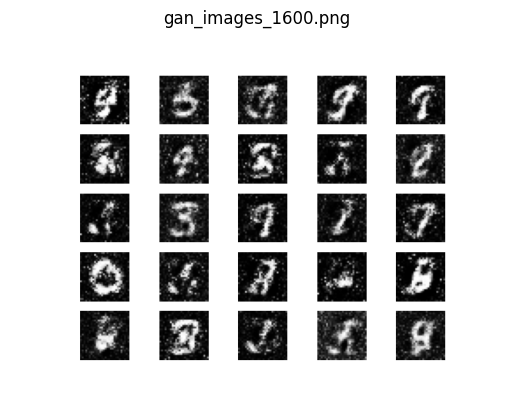

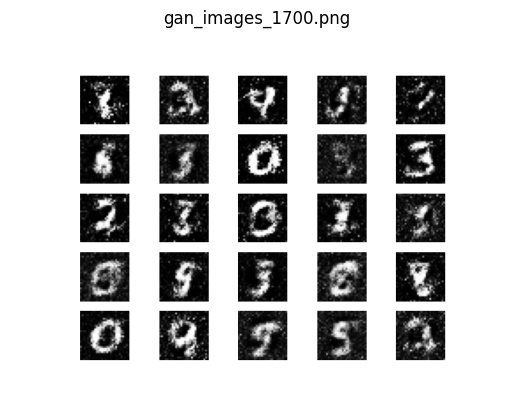

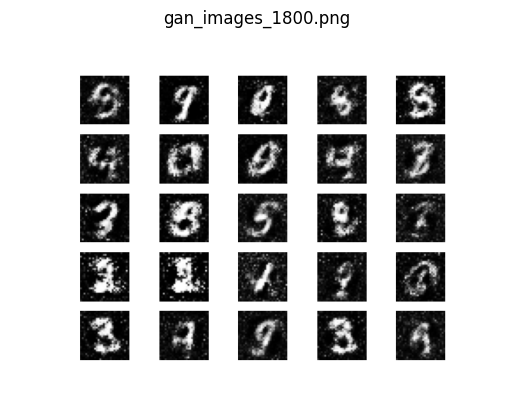

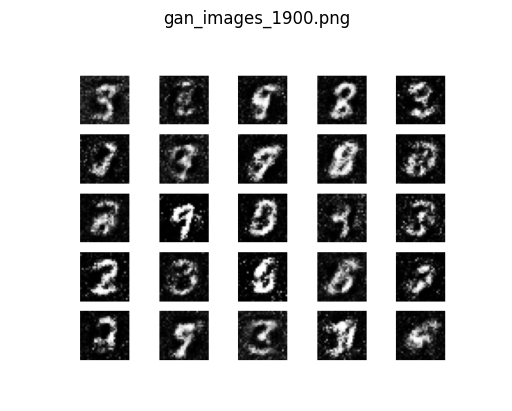

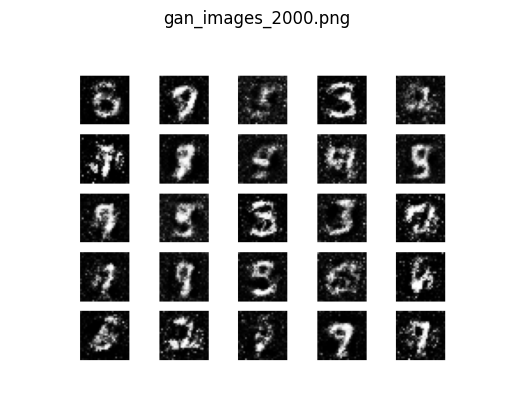

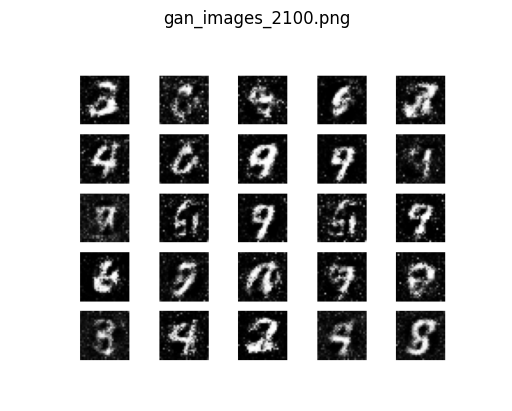

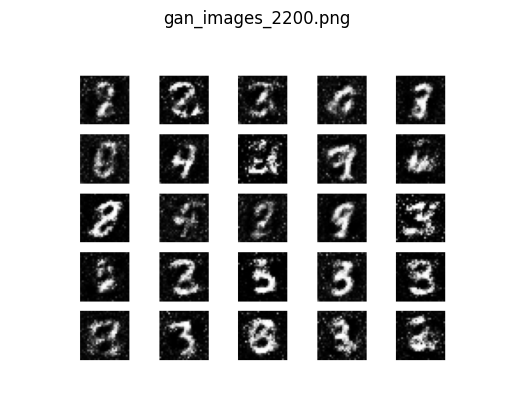

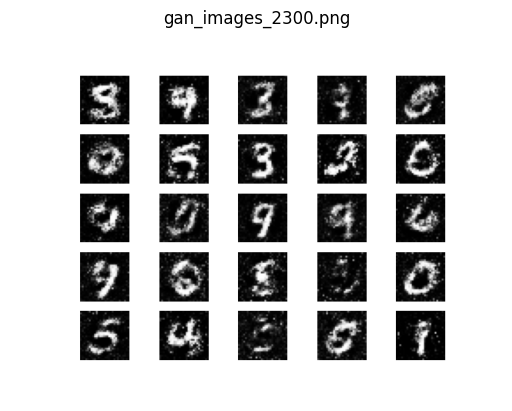

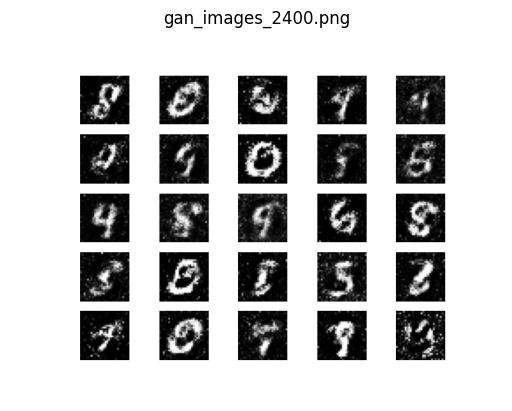

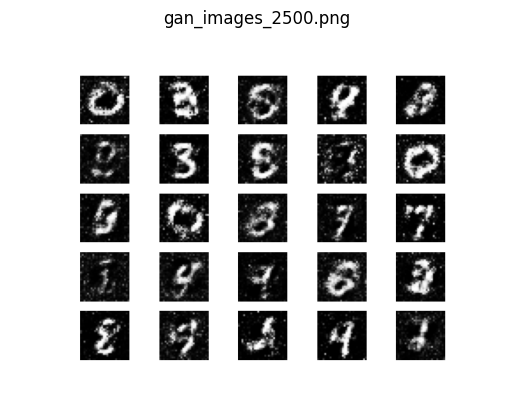

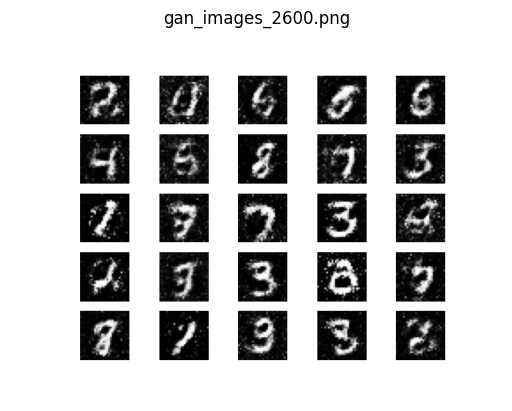

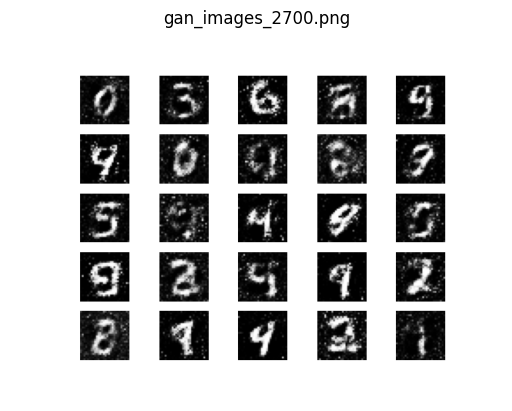

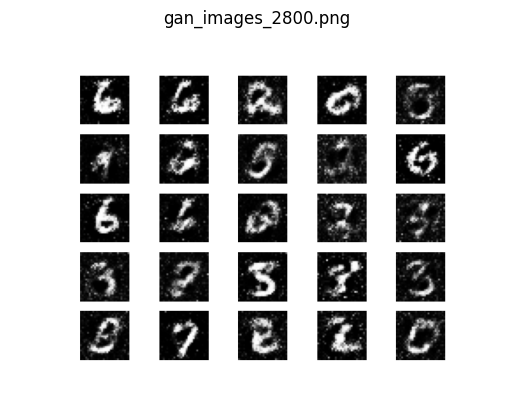

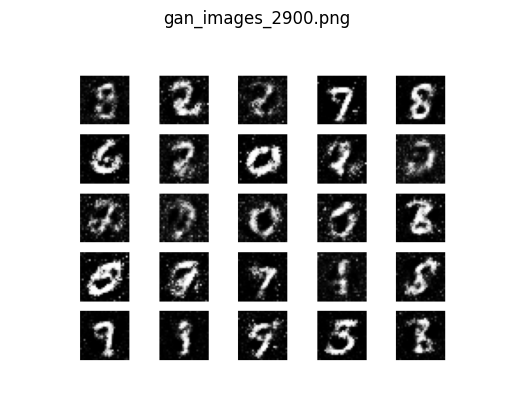

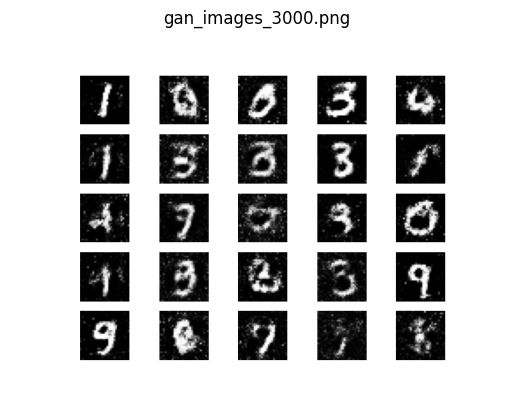

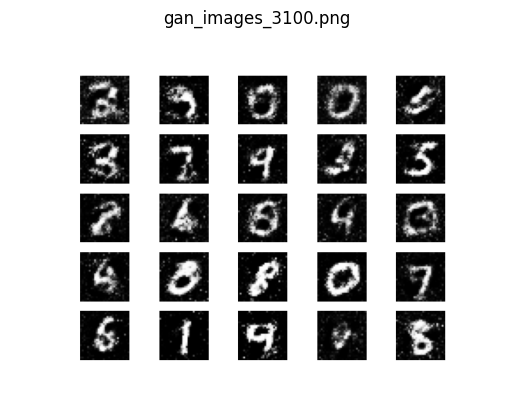

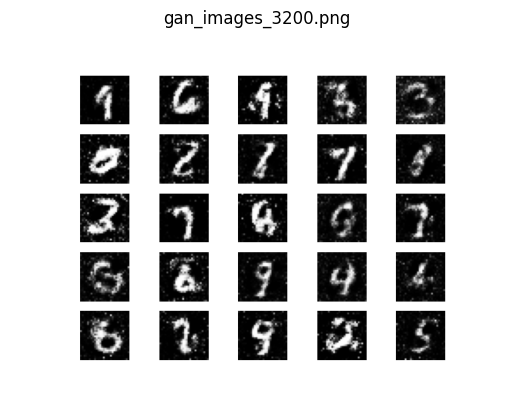

In [5]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directory path
directory_path = '/content'

# List all files in the directory
files = os.listdir(directory_path)

# Filter out image files with numeric values in their filenames
image_files = [f for f in files if re.match(r'gan_images_\d+\.png', f)]

# Sort image files based on numeric value in the filename
image_files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

# Display each image
for image_file in image_files:
    img_path = os.path.join(directory_path, image_file)
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')
    plt.show()